In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
torch.manual_seed(1)

In [5]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print(DEVICE)

cpu


In [6]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=False)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("train_dataset size:", len(train_dataset),"\ntest_dataset size:", len(test_dataset))

train_dataset size: 60000 
test_dataset size: 10000


In [5]:
# randomLabelsTrain = torch.tensor(np.random.randint(0,10, (len(train_dataset)),))
# print(len(randomLabelsTrain))
# randomLabelsTest = torch.tensor(np.random.randint(0,10, (len(test_dataset)),))
# print(len(randomLabelsTest))

In [1]:
# train_dataset.targets = randomLabelsTrain
# test_dataset.targets = randomLabelsTest

In [7]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=100, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=100, 
                                          shuffle=False)

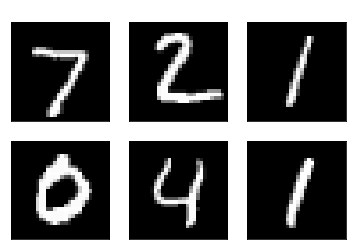

In [8]:
examples = iter(test_loader)
example_data, example_targets = examples.next()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title("Actual Val: {}".format(example_targets[i]),color='white')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [9]:
# Hyper-parameters 
input_size = 784 # 28x28
max_epochs = 2000
learning_rate = 0.01
kernel_size = 4
weight_decay_val = 1e-4
dropout = 0.25

In [29]:
# class CNN1(nn.Module):
#     def __init__(self,):
#         super(CNN1, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size) #1st Convolution
#         self.pool = nn.MaxPool2d(2, 2)   #pool_size=2, strides=2 
#         self.conv2 = nn.Conv2d(10, 20, kernel_size) #2nd Convolution
#         self.fc1 = nn.Linear(320, 50) #((I/P - Filter + 2*Pad)/Stride)+1 
#         self.dropout = nn.Dropout(dropout)
#         self.fc2 = nn.Linear(50, 100)
#         self.fc3 = nn.Linear(100, 10)

#     def forward(self, x):
#         # -> n, 3, 32, 32
#         x = self.pool(F.relu(self.conv1(x)))  
#         x = self.pool(F.relu(self.conv2(x)))  
#         x = x.view(-1, 320)            #Flattening 
#         x = F.relu(self.fc1(x))        #Fully Connected NN   
#         x = self.dropout(x)   
#         x = F.relu(self.fc2(x))        #Fully Connected NN           
#         x = self.fc3(x)                #O/P Layer       
#         return x

In [10]:
class RandMnist (nn.Module):
    def __init__(self,) :
        super(RandMnist,self).__init__()
        self.fc1 = nn.Linear(784, 100) #((I/P - Filter + 2*Pad)/Stride)+1 
        self.fc2 = nn.Linear(100, 10)
    def forward(self, x):
        x = F.relu(self.fc1(x))        #Fully Connected NN   
        x = self.fc2(x)               #O/P Layer                   
        return x

In [11]:
rmnist = RandMnist()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rmnist.parameters(), lr=learning_rate) #, weight_decay = weight_decay_val)

a=[]
for i in rmnist.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 1:', np.sum(a),)

Total no of parameters in Model 1: 79510


In [18]:
test_loader.images

AttributeError: 'DataLoader' object has no attribute 'images'

In [37]:
# train_losses = []
# train_epoch = []
# train_acc = []
# test_losses = []
# test_epoch = []
# not_converged =True
# epoch = 0
# Train the model

#for epoch in range(num_epochs):
def testFunc(model,num_epochs):
    n_total_steps = len(train_loader)
    train_losses = []
    train_epoch = []
    train_acc = []
    test_losses = []
    test_epoch = []
    netTest_acc1Arr = []
    #not_converged =True
    
    epoch = 0

    for epoch in range(num_epochs):
        epoch += 1
        n_correct = 0
        n_samples = 0
        for i, (images, labels) in enumerate(train_loader):  
            labels_rand = labels.detach().numpy()
            np.random.shuffle(labels_rand)
            labels_rand = torch.from_numpy(labels_rand)
            
            # Forward pass
            prediction = model(images.view(-1,784))
            #prediction = model(images)
            loss = loss_func(prediction, labels_rand)
            #loss = F.nll_loss(prediction, labels_rand)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels_rand).sum().item()
            acc = 100.0 * n_correct / n_samples

            # if (i+1) % 100 == 0:
            #     print (f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], TrainLoss: {loss.item():.4f}')#,TestLoss: {test_loss.item():.4f}')
            #     train_epoch.append(epoch)
            #     train_losses.append(loss.item())
            #     print(f'Epoch [{epoch}/{num_epochs}], TrainAccuracy : {acc} %') #, TestAccuracy : {netTest_acc1}%')
            #     train_acc.append(acc)

            with torch.no_grad():
                n_correct = 0
                n_samples = 0
                n_class_correct = [0 for j in range(10)]
                n_class_samples = [0 for j in range(10)]
                for test_images, test_labels in test_loader:
                    outputs = model(test_images.view(-1,784))
                    test_loss = loss_func(outputs, test_labels)
                    test_losses.append(test_loss)
                    # max returns (value ,index)
                    _, predicted = torch.max(outputs, 1)
                    n_samples += test_labels.size(0)
                    n_correct += (predicted == test_labels).sum().item()
                    
                    for j in range(100):
                        label = test_labels[j]
                        pred = predicted[j]
                        if (label == pred):
                            n_class_correct[label] += 1
                        n_class_samples[label] += 1
                netTest_acc1 = 100.0 * n_correct / n_samples
                netTest_acc1Arr.append(netTest_acc1)

            if (i+1) % 100 == 0:
                print (f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], TrainLoss: {loss.item():.4f},TestLoss: {test_loss.item():.4f}')
                train_epoch.append(epoch)
                train_losses.append(loss.item())
                print(f'Epoch [{epoch}/{num_epochs}], TrainAccuracy : {acc} %, TestAccuracy : {netTest_acc1}%')

    
            
                        
    return train_epoch,train_losses,train_acc,test_losses,netTest_acc1Arr

In [38]:
train_epoch,train_losses,train_acc,test_losses,netTest_acc1Arr = testFunc(rmnist,1000)

Epoch [1/1000], Step [100/100], TrainLoss: 2.3028,TestLoss: 2.2970
Epoch [1/1000], TrainAccuracy : 11.367924528301886 %, TestAccuracy : 11.35%
Epoch [2/1000], Step [100/100], TrainLoss: 2.3015,TestLoss: 2.2964
Epoch [2/1000], TrainAccuracy : 11.320754716981131 %, TestAccuracy : 11.35%
Epoch [3/1000], Step [100/100], TrainLoss: 2.2967,TestLoss: 2.3003
Epoch [3/1000], TrainAccuracy : 11.556603773584905 %, TestAccuracy : 11.35%
Epoch [4/1000], Step [100/100], TrainLoss: 2.3059,TestLoss: 2.2981
Epoch [4/1000], TrainAccuracy : 11.40566037735849 %, TestAccuracy : 11.35%
Epoch [5/1000], Step [100/100], TrainLoss: 2.3008,TestLoss: 2.2981
Epoch [5/1000], TrainAccuracy : 11.367924528301886 %, TestAccuracy : 11.35%
Epoch [6/1000], Step [100/100], TrainLoss: 2.2979,TestLoss: 2.2965
Epoch [6/1000], TrainAccuracy : 11.339622641509434 %, TestAccuracy : 11.35%
Epoch [7/1000], Step [100/100], TrainLoss: 2.3021,TestLoss: 2.2985
Epoch [7/1000], TrainAccuracy : 11.38679245283019 %, TestAccuracy : 11.35%
E

KeyboardInterrupt: 

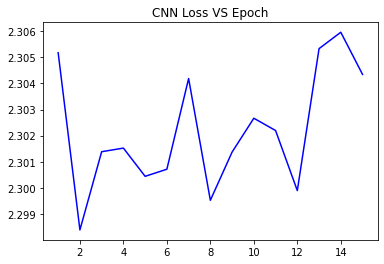

In [19]:
#plot
plt.plot(train_epoch,train_losses,color="blue")
plt.title('CNN Loss VS Epoch')
plt.show()

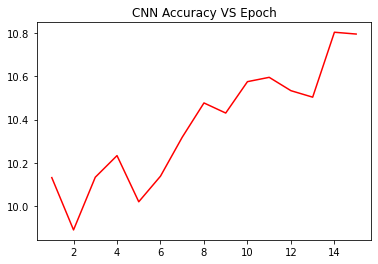

In [35]:
#plot
plt.plot(train_epoch,train_acc,color="red")
plt.title('CNN Accuracy VS Epoch')
plt.show()

In [22]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for test_images, test_labels in test_loader:
        outputs = rmnist(test_images.view(-1,784))
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += test_labels.size(0)
        n_correct += (predicted == test_labels).sum().item()
        
        for i in range(100):
            label = test_labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {netTest_acc1} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {i}: {acc} %')

Accuracy of the network: 11.35 %
Accuracy of 0: 0.0 %
Accuracy of 1: 100.0 %
Accuracy of 2: 0.0 %
Accuracy of 3: 0.0 %
Accuracy of 4: 0.0 %
Accuracy of 5: 0.0 %
Accuracy of 6: 0.0 %
Accuracy of 7: 0.0 %
Accuracy of 8: 0.0 %
Accuracy of 9: 0.0 %


In [5]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        prediction = cnn1(images)
        # max returns (value ,index)
        _, predicted = torch.max(prediction.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1} %')

NameError: name 'test_loader' is not defined

In [39]:
import os
import optuna
from optuna.trial import TrialState

In [43]:
def rmnist2(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    in_features = 28 * 28
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, 10))
    layers.append(nn.LogSoftmax(dim=1))

    return nn.Sequential(*layers)

In [65]:
def objective(trial):

    # Generate the model.
    model = rmnist2(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
    

    # Training of the model.
    for epoch in range(max_epochs):
        model.train()
        correct = 0
        N_TRAIN_EXAMPLES = 600*90
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * 600 >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
            
            #target randomizer
            target_rand = target.detach().numpy()
            np.random.shuffle(target_rand)
            target_rand = torch.from_numpy(target_rand)

            #Forward Pass
            optimizer.zero_grad()
            output = model(data)
            #loss = F.nll_loss(output, target)
            loss = F.nll_loss(output, target_rand)
            loss.backward()
            optimizer.step()
            # Get the index of the max log-probability.
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

        # # Validation of the model.
        # model.eval()
        # correct = 0
        # with torch.no_grad():
        #     for batch_idx, (data, target) in enumerate(valid_loader):
        #         # Limiting validation data.
        #         if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
        #             break
        #         data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
        #         output = model(data)
        #         # Get the index of the max log-probability.
        #         pred = output.argmax(dim=1, keepdim=True)
        #         correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(test_loader.dataset), N_TRAIN_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy


In [89]:
best_pram = []
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
best_pram.append(trial)

[I 2022-02-04 15:48:33,658] A new study created in memory with name: no-name-6e38e5ac-11bf-405c-b77e-dc7a3965f57f
[I 2022-02-04 15:49:58,809] Trial 0 finished with value: 0.5737 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'dropout_l0': 0.3147000482390166, 'n_units_l1': 83, 'dropout_l1': 0.3755580390141433, 'optimizer': 'RMSprop', 'lr': 1.5571614629193746e-05}. Best is trial 0 with value: 0.5737.
[I 2022-02-04 15:51:22,560] Trial 1 finished with value: 0.5813 and parameters: {'n_layers': 2, 'n_units_l0': 81, 'dropout_l0': 0.47559396076741306, 'n_units_l1': 54, 'dropout_l1': 0.24763114371031042, 'optimizer': 'RMSprop', 'lr': 0.08011318942978086}. Best is trial 1 with value: 0.5813.
[I 2022-02-04 15:52:48,902] Trial 2 finished with value: 0.5858 and parameters: {'n_layers': 1, 'n_units_l0': 78, 'dropout_l0': 0.2256706585427175, 'optimizer': 'RMSprop', 'lr': 6.993744344468027e-05}. Best is trial 2 with value: 0.5858.
[I 2022-02-04 15:54:23,002] Trial 3 finished with value: 0.6062 and

Study statistics: 
  Number of finished trials:  13
  Number of pruned trials:  6
  Number of complete trials:  7
Best trial:
  Value:  0.6062
  Params: 
    n_layers: 2
    n_units_l0: 119
    dropout_l0: 0.37593694029285274
    n_units_l1: 22
    dropout_l1: 0.4837147507853665
    optimizer: RMSprop
    lr: 0.01110369406935113


In [12]:
class RandMnist3 (nn.Module):
    def __init__(self,) :
        super(RandMnist3,self).__init__()
        self.fc1 = nn.Linear(784, 45) #((I/P - Filter + 2*Pad)/Stride)+1 
        self.dropout1 = nn.Dropout(0.24608164624582957)
        self.fc2 = nn.Linear(45, 13)
        self.dropout2 = nn.Dropout(0.37326854044559243)
        self.fc3 = nn.Linear(13, 10)
    def forward(self, x):
        x = F.relu(self.fc1(x))        #Fully Connected NN 
        x = self.dropout1(x)  
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)               #O/P Layer                   
        return x

In [19]:
rmnist3 = RandMnist3()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rmnist3.parameters(), lr=0.005325277529448175)

a=[]
for i in rmnist3.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 1:', np.sum(a),)

Total no of parameters in Model 1: 36063


In [20]:
train_epoch,train_losses,train_acc,test_losses,netTest_acc1Arr=testFunc(rmnist3,1500)

Epoch [1/1500], Step [100/100], Loss: 2.3009
Epoch [1/1500], Accuracy : 10.636666666666667 %
Epoch [2/1500], Step [100/100], Loss: 2.3054
Epoch [2/1500], Accuracy : 11.236666666666666 %
Epoch [3/1500], Step [100/100], Loss: 2.3023
Epoch [3/1500], Accuracy : 11.236666666666666 %
Epoch [4/1500], Step [100/100], Loss: 2.3038
Epoch [4/1500], Accuracy : 11.236666666666666 %
Epoch [5/1500], Step [100/100], Loss: 2.3043
Epoch [5/1500], Accuracy : 11.236666666666666 %
Epoch [6/1500], Step [100/100], Loss: 2.3027
Epoch [6/1500], Accuracy : 11.236666666666666 %
Epoch [7/1500], Step [100/100], Loss: 2.3000
Epoch [7/1500], Accuracy : 11.236666666666666 %
Epoch [8/1500], Step [100/100], Loss: 2.3010
Epoch [8/1500], Accuracy : 11.24 %
Epoch [9/1500], Step [100/100], Loss: 2.2985
Epoch [9/1500], Accuracy : 11.24 %
Epoch [10/1500], Step [100/100], Loss: 2.3027
Epoch [10/1500], Accuracy : 11.126666666666667 %
Epoch [11/1500], Step [100/100], Loss: 2.3009
Epoch [11/1500], Accuracy : 11.236666666666666 %

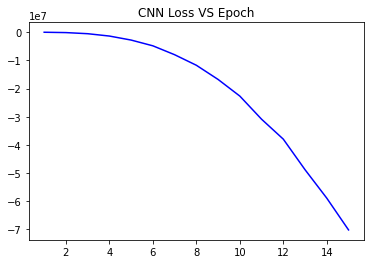

In [86]:
#plot
plt.plot(train_epoch,train_losses,color="blue")
plt.title('CNN Loss VS Epoch')
plt.show()

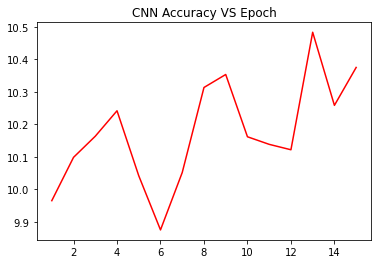

In [87]:
#plot
plt.plot(train_epoch,train_acc,color="red")
plt.title('CNN Accuracy VS Epoch')
plt.show()